# Donut model for Document parsing

Parsing is a process that extracts data from structured or semi-structured PDFs by analyzing their internal structure and metadata. Parsing software reads the PDF file and identifies the elements and attributes that define the data, such as tags, fields, coordinates, or styles. Parsing can be useful for extracting data from native or digital PDFs, such as reports, catalogs, or ebooks. However, parsing also has some limitations and challenges. [read more](https://www.linkedin.com/advice/0/what-pros-cons-using-ocr-vs-parsing-pdf-data-extraction)

In [1]:
import re
from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset, load_from_disk
import torch

/home/pietro/miniconda3/envs/tfx_ai_document_analysis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

2024-02-05 00:30:58.653201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [4]:
# Load dataset
dataset = load_from_disk("../data/raw/DocLayNet-small")
dataset.set_format("pandas")
dataset = dataset.remove_columns(['bboxes_line','page_hash','original_filename','page_no','coco_width','coco_height','collection','original_width','original_height','num_pages'])
ds_train = dataset['train'][:]

### Test the model for image from DocLayNet dataset

We see the model only gets only the first sentence from the top of the image and not the rest

{'nm': '270 Notes to the consolidated financial statements of Aepon N.V. Note 50'}


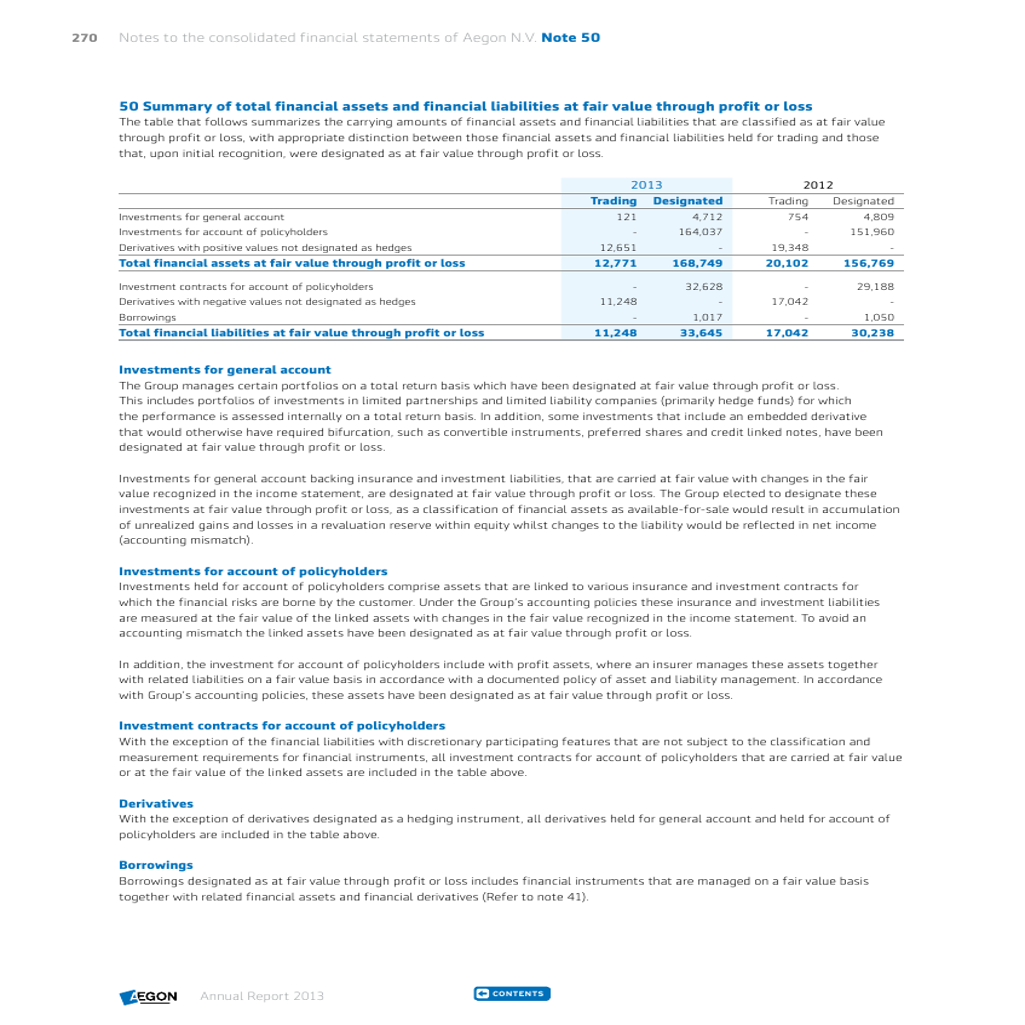

In [12]:
# load document image
dataset = load_dataset("hf-internal-testing/example-documents", split="test")
# image = dataset[2]["image"]
image = ds_train['image'][0]

# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
pixel_values = processor(image, return_tensors="pt").pixel_values
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

print(processor.token2json(sequence))
ds_train['image'][0]

### We will test the models hability to extract text with said text is isolated on the image

We see that the model gets a lot of words right but also alucinates a lot of the text.

{'text_sequence': ' Summary of total financial assets and financial liabilities就是在 fair value through profit or loss coincide llabittites that are classified as at fair value processors." and financial assetts and financial liabilities that are classified as at fair value profit or loss. with appropriate distinction between those financial assets and financial liabilities held for trading and those profit or loss. with apropriate designated as at fair value through profit or loss. though profit or loss. wealth assett and financial tisubstitutes would not assumentary value profit or loss. with a profit does. with assets and financial boosted as at fair value though profit or loss. trendal tisubstitutes held for trading and those requisited as at fair value though profit or loss.'}


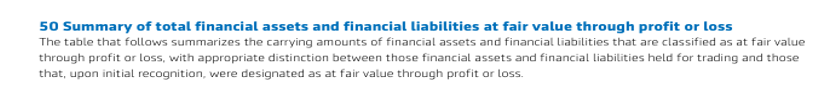

In [45]:
bbox = (80, 80, 900, 170)
image_bbox = ds_train['image'][0].crop(bbox)

# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
pixel_values = processor(image_bbox, return_tensors="pt").pixel_values
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

print(processor.token2json(sequence))
image_bbox
